In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import pandas as pd
from numba import jit
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

In [2]:
def num_derivative(x,t):
    d = np.zeros(len(t)-1)
    for i in range(len(t)-1):
        d[i] = (x[i+1,0]-x[i,1])/(t[i+1]-t[i])
    return d

def clean_data(x_data,NT,col):
    x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
    fin_index = np.min(np.where(x_clean[:,col]>NT))
    x = x_clean[:fin_index,1:]
    t = x_clean[:fin_index,0]/60.0
    return x,t

def growth_rate1(t,q0):
    g=0.0359
    K=1.5355
    N=x1[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)*N
    return A*B

def growth_rate2(t,q0):
    g=0.0359
    K=1.5355
    N=x2[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)*N
    return A*B

def err1(q0, t, y):
    return growth_rate1(t,q0) - y

def err2(q0, t, y):
    return growth_rate2(t,q0) - y


def err_global(p, t1, t2, dx1, dx2):
    er1 = err1(p, t1, dx1)
    er2 = err2(p, t2, dx2)
    return np.concatenate((er1, er2))


def log_growth_rate1(t,q0):
    g=0.0359
    K=1.5355
    N=x1[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)
    return A*B

def log_growth_rate2(t,q0):
    g=0.0359
    K=1.5355
    N=x2[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)
    return A*B

def log_err1(q0, t, y):
    return log_growth_rate1(t,q0) - y

def log_err2(q0, t, y):
    return log_growth_rate2(t,q0) - y

def log_err_global(p, t1, t2, dx1, dx2):
    er1 = log_err1(p, t1, dx1)
    er2 = log_err2(p, t2, dx2)
    return np.concatenate((er1, er2))

# another method, using curve fit

In [ ]:
f,axes = plt.subplots(1,2,figsize=(7,3))
col=1
x1_data=pd.read_csv("NT10.csv").values
x1,t1 = clean_data(x1_data,1,col)
x2_data=pd.read_csv("NT05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)

dx1 = num_derivative(x1,t1)
dx2 = num_derivative(x2,t2)
axes[0].scatter(t1[:len(t1)-1],dx1)
axes[0].scatter(t2[:len(t2)-1],dx2)
axes[0].set_xlabel('Time (min)')
axes[0].set_ylabel(r'$\dfrac{dN}{dt}$')

axes[1].scatter(x1[:len(t1)-1,0],dx1/x1[:len(t1)-1,1])
axes[1].scatter(x2[:len(t2)-1,0],dx2/x2[:len(t2)-1,1])
axes[1].set_xlabel('N')
axes[1].set_ylabel(r'$\dfrac{d[log(N)]}{dt}$')
plt.tight_layout()
plt.show()

In [ ]:
C=(15e3-200)/15e3
plt.plot(t1,x1[:,0]-200*x1[:,0]/15e3)  #predilution -200
plt.plot(t1,x1[:,1])


In [ ]:
p_global = [0.1]
p_best, ier = leastsq(err_global, p_global, args=(t1[:len(t1)-1], t2[:len(t2)-1], dx1, dx2))
print(p_best)
f,axes = plt.subplots(1,2,figsize=(8,3))
axes[0].scatter(t1[:len(t1)-1],dx1,label='NT=1',color='C0')
axes[0].plot(t1[:len(t1)-1], growth_rate1(t1[:len(t1)-1], p_best),color='y', label='Simulated',linewidth=3)
axes[1].scatter(t2[:len(t2)-1],dx2,label='NT=0.5',color='C1')
axes[1].plot(t2[:len(t2)-1], growth_rate2(t2[:len(t2)-1], p_best),color='g', label='Simulated',linewidth=3)
for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{dN}{dt}$')
    axes[i].legend()
plt.tight_layout(h_pad=1)

f,axes = plt.subplots(1,2,figsize=(8,3))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='NT=1')
axes[0].plot(x1[:len(t1)-1,1], growth_rate1(t1[:len(t1)-1], p_best)/x1[:len(t1)-1,1],color='y', label='Simulated',linewidth=3)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='NT=0.5')
axes[1].plot(x2[:len(t2)-1,1], growth_rate2(t2[:len(t2)-1], p_best)/x2[:len(t2)-1,1],color='g', label='Simulated',linewidth=3)
for i in range(2):
    axes[i].set_xlabel('N')
    axes[i].set_ylabel(r'$\dfrac{d[log(N)]}{dt}$')
    axes[i].set_ylim([-0.03,0.03])
    #axes[i].set_xlim([0.1,1])
    axes[i].legend(loc='lower right')
plt.tight_layout(h_pad=1)

# Fit from logistic growth rate

In [ ]:
p_global = [0.2]
p_best, ier = leastsq(log_err_global, p_global, args=(t1[:len(t1)-1], t2[:len(t2)-1], dx1/x1[:len(t1)-1,1], dx2/x2[:len(t2)-1,1]))
print(p_best)
f,axes = plt.subplots(1,2,figsize=(8,3))
axes[0].scatter(t1[:len(t1)-1],dx1,label='NT=1',color='C0')
axes[0].plot(t1[:len(t1)-1], growth_rate1(t1[:len(t1)-1], p_best),color='y', label='Simulated',linewidth=3)
axes[1].scatter(t2[:len(t2)-1],dx2,label='NT=0.5',color='C1')
axes[1].plot(t2[:len(t2)-1], growth_rate2(t2[:len(t2)-1], p_best),color='g', label='Simulated',linewidth=3)
for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{dN}{dt}$')
    axes[i].legend()
plt.tight_layout(h_pad=1)

f,axes = plt.subplots(1,2,figsize=(8,3))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='NT=1')
axes[0].plot(x1[:len(t1)-1,1], log_growth_rate1(t1[:len(t1)-1], p_best),color='y', label='Simulated',linewidth=3)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='NT=0.5')
axes[1].plot(x2[:len(t2)-1,1], log_growth_rate2(t2[:len(t2)-1], p_best),color='g', label='Simulated',linewidth=3)
for i in range(2):
    axes[i].set_xlabel('N')
    axes[i].set_ylabel(r'$\dfrac{d[log(N)]}{dt}$')
    axes[i].set_ylim([-0.03,0.03])
    axes[i].legend(loc='lower right')
plt.tight_layout(h_pad=1)

# Smoothed data

In [ ]:
f,axes = plt.subplots(1,2,figsize=(7,3))
col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)

dx1 = num_derivative(x1,t1)
dx2 = num_derivative(x2,t2)
axes[0].scatter(t1[:len(t1)-1],dx1,s=10)
axes[0].scatter(t2[:len(t2)-1],dx2,s=10)
axes[0].set_xlabel('Time (min)')
axes[0].set_ylabel(r'$\dfrac{dN}{dt}$')

axes[1].scatter(x1[:len(t1)-1,0],dx1/x1[:len(t1)-1,1],s=10)
axes[1].scatter(x2[:len(t2)-1,0],dx2/x2[:len(t2)-1,1],s=10)
axes[1].set_xlabel('N')
axes[1].set_ylabel(r'$\dfrac{d[log(N)]}{dt}$')

#for i in range(2):
#    axes[i].set_ylim([-0.005,0.02])
plt.tight_layout()
plt.show()



In [ ]:
def growth_rate1(t,q0):
    g=0.0359
    K=1.5355
    N=x1[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)*N
    return A*B

def growth_rate2(t,q0):
    g=0.0359
    K=1.5355
    N=x2[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)*N
    return A*B

def err1(q0, t, y):
    return growth_rate1(t,q0) - y

def err2(q0, t, y):
    return growth_rate2(t,q0) - y


def err_global(p, t1, t2, dx1, dx2):
    er1 = err1(p, t1, dx1)
    er2 = err2(p, t2, dx2)
    return np.concatenate((er1, er2))


def log_growth_rate1(t,q0):
    g=0.0359
    K=1.5355
    N=x1[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)
    return A*B

def log_growth_rate2(t,q0):
    g=0.0359
    K=1.5355
    N=x2[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)
    return A*B


def log_err1(q0, t, y):
    return log_growth_rate1(t,q0) - y

def log_err2(q0, t, y):
    return log_growth_rate2(t,q0) - y

def log_err_global(p, t1, t2, dx1, dx2):
    er1 = log_err1(p, t1, dx1)
    er2 = log_err2(p, t2, dx2)
    return np.concatenate((er1, er2))

In [ ]:
p_global = [0.1]
p_best, ier = leastsq(err_global, p_global, args=(t1[:len(t1)-1], t2[:len(t2)-1], dx1, dx2))

print(p_best)
f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(t1[:len(t1)-1],dx1,label='Numerical',color='C0',s=10)
axes[0].plot(t1[:len(t1)-1], growth_rate1(t1[:len(t1)-1], p_best),color='y', label=r'$g(N)N$',linewidth=2)
axes[1].scatter(t2[:len(t2)-1],dx2,label='Numerical',color='C1',s=10)
axes[1].plot(t2[:len(t2)-1], growth_rate2(t2[:len(t2)-1], p_best),color='g', label=r'$g(N)N$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{\Delta t}$')
    axes[i].set_ylim(-0.005,0.02)
    axes[i].legend()
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout(h_pad=1)

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='Numerical',s=10)
axes[0].plot(x1[:len(t1)-1,1], growth_rate1(t1[:len(t1)-1], p_best)/x1[:len(t1)-1,1],color='y', label=r'$g(N)$',linewidth=2)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='Numerical',s=10)
axes[1].plot(x2[:len(t2)-1,1], growth_rate2(t2[:len(t2)-1], p_best)/x2[:len(t2)-1,1],color='g', label=r'$g(N)$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel('N')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{N_p(t_{k}) \Delta t}$')
    axes[i].set_ylim([-0.01,0.03])
    #axes[i].set_xlim([0.1,1])
    axes[i].legend(loc='lower right')
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout(h_pad=1)

fit using log growth

In [ ]:
p_global = [0.2]
p_best, ier = leastsq(log_err_global, p_global, args=(t1[:len(t1)-1], t2[:len(t2)-1], dx1/x1[:len(t1)-1,1], dx2/x2[:len(t2)-1,1]))
print(p_best)
f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(t1[:len(t1)-1],dx1,label='Numerical',color='C0',s=10)
axes[0].plot(t1[:len(t1)-1], growth_rate1(t1[:len(t1)-1], p_best),color='y', label=r'$g(N)N$',linewidth=2)
axes[1].scatter(t2[:len(t2)-1],dx2,label='Numerical',color='C1',s=10)
axes[1].plot(t2[:len(t2)-1], growth_rate2(t2[:len(t2)-1], p_best),color='g', label=r'$g(N)N$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{\Delta t}$')
    axes[i].legend()
plt.tight_layout(h_pad=1)
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')


f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='NT=1',s=10)
axes[0].plot(x1[:len(t1)-1,1], growth_rate1(t1[:len(t1)-1], p_best)/x1[:len(t1)-1,1],color='y', label=r'$g(N)$',linewidth=2)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='NT=0.5',s=10)
axes[1].plot(x2[:len(t2)-1,1], growth_rate2(t2[:len(t2)-1], p_best)/x2[:len(t2)-1,1],color='g', label=r'$g(N)$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel('N')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{N_p(t_{k}) \Delta t}$')
    axes[i].set_ylim([-0.03,0.03])
    #axes[i].set_xlim([0.1,1])
    axes[i].legend(loc='lower right')
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout(h_pad=1)

# Trajectory simulation

In [3]:
def dNdt(t, z,q0):
    g=0.0359
    K=1.5355
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    C=200/(delt*15e3)
    return A*B*(15e3-200)/15e3-(C*z)

def lag(t, z,q0):
    g=0.0359
    K=1.5355
    A=1./(1+(1./q0)*np.exp(-g*t))

    return A

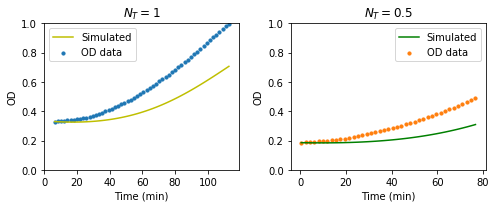

In [4]:
col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)

f,axes = plt.subplots(1,2,figsize=(7,3))
N=x1[:len(t1),0]
q0=0.1747
delt = t1[1]-t1[0]
sol1 = solve_ivp(lambda t, z: dNdt(t, z,q0), [t1[0],t1[-1]], [N[0]],dense_output=True)
axes[0].plot(t1,np.ndarray.flatten(sol1.sol(t1)),color='y',label='Simulated')
axes[0].scatter(t1,N,s=10,label='OD data')
axes[0].set_title(r'$N_T=1$')

N=x2[:len(t2),0]
q0=0.2036
delt = t2[1]-t2[0]
sol1 = solve_ivp(lambda t, z: dNdt(t, z,q0), [t2[0],t2[-1]], [N[0]],dense_output=True)
axes[1].plot(t2,np.ndarray.flatten(sol1.sol(t2)),color='g',label='Simulated')
axes[1].scatter(t2,N,s=10,label='OD data',color='C1')
axes[1].set_title(r'$N_T=0.5$')

for i in range(2):
    axes[i].legend()
    axes[i].set_ylabel('OD')
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylim([0,1])

plt.tight_layout()

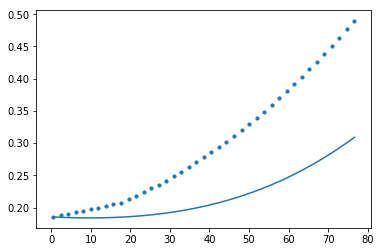

In [5]:
N=x2[:len(t2),1]
q0=0.2035
delt = t2[1]-t2[0]
sol2 = solve_ivp(lambda t, z: dNdt(t, z,q0), [0,t2[-1]], [N[0]],dense_output=True)
t = np.linspace(t2[0], t2[-1], 1000)
plt.plot(t,np.ndarray.flatten(sol2.sol(t)))
plt.scatter(t2,N,s=10)

In [ ]:
t1[2]-t1[1]

In [ ]:
plt.plot(t1,lag(t1,N,0.9))
plt.ylim([0,1])

In [ ]:
C=(15e3-200)/15e3
C1=200/(15e3*delt)
print(0.0137*C+C1)

In [ ]:
def dNdt(t, z):
    g=0.0359
    K=1.5355
    #A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    C=300/(delt*15e3)
    return B*(15e3-200)/15e3-(C*z)

In [ ]:
delt = t1[1]-t1[0]
sol1 = solve_ivp(lambda t, z: dNdt(t, z), [0,1200], [1],dense_output=True)

In [ ]:
t = np.linspace(t1[0], 1200, 1000)
plt.plot(t,np.ndarray.flatten(sol1.sol(t)))
plt.ylim([0,1.2])
#plt.scatter(t1,x1[:,0],s=10)

# estimate from actual trajectories

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import leastsq
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

In [7]:
def clean_data(x_data,NT,col):
    x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
    fin_index = np.min(np.where(x_clean[:,col]>NT))
    x = x_clean[:fin_index,1:]
    t = x_clean[:fin_index,0]/60.0
    return x,t

def num_derivative(x,t):
    d = np.zeros(len(t)-1)
    for i in range(len(t)-1):
        d[i] = (x[i+1,0]-x[i,1])/(t[i+1]-t[i])
    return d

def dNdt_est(z, t, q0):
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    C=200/(delt*15e3)
    return A*B*(15e3-200)/15e3-(C*z)

def err_global(q0,t1,t2,y1,y2):
    sol1 = np.ndarray.flatten(odeint(dNdt_est, y1[0], t1, args=(q0,)))
    sol2 = np.ndarray.flatten(odeint(dNdt_est, y2[0], t2, args=(q0,)))
    er1 = sol1 - y1
    er2 = sol2 - y2
    return np.concatenate((er1, er2))

col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1.0,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)
dx1 = num_derivative(x1,t1)
dx2 = num_derivative(x2,t2)

N1 = x1[:len(t1),0]
N2 = x2[:len(t2),0]
delt=t1[1]-t1[0]
g=0.0359
K=1.5355
p_global = 10
p_best, ier = leastsq(err_global, p_global, args=(t1,t2,N1,N2))


In [ ]:
p_best

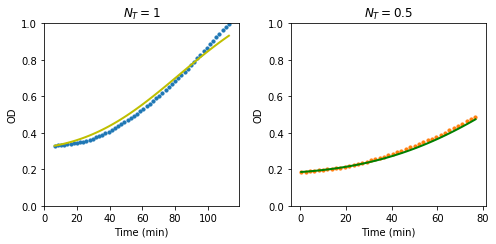

In [8]:
f,axes = plt.subplots(1,2,figsize=(7,3.5))
delt = t1[1]-t1[0]
sol1 = np.ndarray.flatten(odeint(dNdt_est,N1[0], t1, args=(p_best,))) 
axes[0].plot(t1,sol1,c='y',linewidth=2)
axes[0].scatter(t1,N1,s=10,color='C0')
axes[0].set_title(r'$N_T=1$')

delt=t2[1]-t2[0]
sol2 = np.ndarray.flatten(odeint(dNdt_est, N2[0], t2, args=(p_best,)))
axes[1].plot(t2,sol2,c='g',linewidth=2)
axes[1].scatter(t2,N2,c='C1',s=10)
axes[1].set_title(r'$N_T=0.5$')


for i in range(2):
    axes[i].set_ylabel('OD')
    axes[i].set_ylim([0,1])
    axes[i].set_xlabel('Time (min)')
plt.tight_layout()

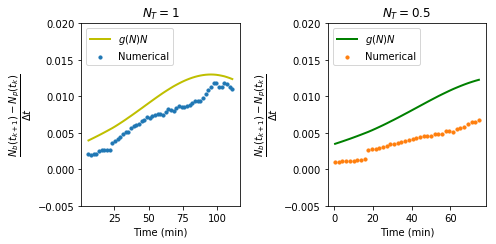

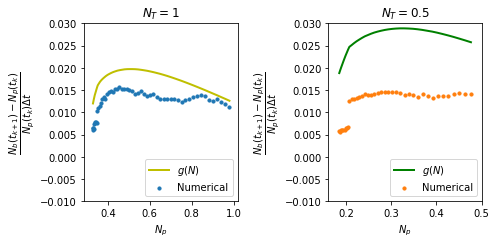

In [9]:
def growth_rate_q0(N,t,q0):
    g=0.0359
    K=1.5355
    N=x1[:len(t),1]
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)*N
    return A*B


f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(t1[:len(t1)-1],dx1,label='Numerical',color='C0',s=10)
axes[0].plot(t1[:len(t1)-1], growth_rate_q0(N1[:len(t1)-1],t1[:len(t1)-1], p_best),color='y', label=r'$g(N)N$',linewidth=2)
axes[1].scatter(t2[:len(t2)-1],dx2,label='Numerical',color='C1',s=10)
axes[1].plot(t2[:len(t2)-1], growth_rate_q0(N2[:len(t2)-1],t2[:len(t2)-1], p_best),color='g', label=r'$g(N)N$',linewidth=2)
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')

for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{\Delta t}$')
    axes[i].set_ylim(-0.005,0.02)
    axes[i].legend(loc='upper left')
plt.tight_layout(h_pad=1)

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='Numerical',s=10)
axes[0].plot(N1[:len(t1)-1], growth_rate_q0(N1[:len(t1)-1],t1[:len(t1)-1], p_best)/N1[:len(t1)-1],color='y', label=r'$g(N)$',linewidth=2)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='Numerical',s=10)
axes[1].plot(N2[:len(t2)-1], growth_rate_q0(N2[:len(t2)-1],t2[:len(t2)-1], p_best)/N2[:len(t2)-1],color='g', label=r'$g(N)$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel(r'$N_p$')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{N_p(t_{k}) \Delta t}$')
    axes[i].set_ylim([-0.01,0.03])
    axes[i].legend(loc='lower right')
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout(h_pad=1)


In [ ]:
axes[0].plot(t1[:len(t1)-1], dNdt_est(N1[:len(t1)-1],t1[:len(t1)-1],p_best),color='y', label='Simulated',linewidth=2)


# Simulation using discrete intervals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

In [2]:
def clean_data(x_data,NT,col):
    x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
    fin_index = np.min(np.where(x_clean[:,col]>NT))
    x = x_clean[:fin_index,1:]
    t = x_clean[:fin_index,0]/60.0
    return x,t

def sim_discrete(t,z,q0):
    g=0.0359
    K=1.5355
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    return A*B

In [3]:
col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1.0,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)

#x1_data=pd.read_csv("NT10.csv").values
#x1,t1 = clean_data(x1_data,1,col)
#x2_data=pd.read_csv("NT05.csv").values
#x2,t2 = clean_data(x2_data,0.5,col)
#dx1 = num_derivative(x1,t1)
#dx2 = num_derivative(x2,t2)

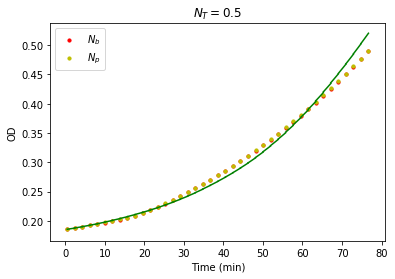

In [17]:
#p_best = 0.1747
p_best = 0.2036

f = plt.figure()
#L=len(t1)
#x0 = x1[0,1]

L=len(t2)
x0 = x2[0,1]
for i in range(L-1):
    #t0 = np.linspace(t1[i],t1[i+1],100)
    #sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t1[i],t1[i+1]], [x0],dense_output=True)
    #sol1 =np.ndarray.flatten(sol.sol(t0))
    #Vdil =15e3*(1-x1[i+1,1]/x1[i+1,0])
    #x0 = (1-Vdil/(15e3))*sol1[-1]
    #x0 = (1-np.random.uniform(0,100)/(15e3))*sol1[-1]
    
    t0 = np.linspace(t2[i],t2[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t2[i],t2[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    Vdil =15e3*(1-x2[i+1,1]/x2[i+1,0])
    x0 = (1-Vdil/(15e3))*sol1[-1]
    
    plt.plot(t0,sol1,color='g')
plt.xlabel('Time (min)')
plt.ylabel('OD')

#plt.scatter(t1,x1[:,0],color='r',s=10,label=r'$N_b$')
#plt.scatter(t1,x1[:,1],color='y',s=10,label=r'$N_p$')
#plt.title(r'$N_T=1$')

plt.scatter(t2,x2[:,0],color='r',s=10,label=r'$N_b$')
plt.scatter(t2,x2[:,1],color='y',s=10,label=r'$N_p$')
plt.title(r'$N_T=0.5$')
plt.legend()

Optimize with respect to discrete intervals

In [18]:
def num_derivative(x,t):
    d = np.zeros(len(t)-1)
    for i in range(len(t)-1):
        d[i] = (x[i+1,0]-x[i,1])/(t[i+1]-t[i])
    return d

def sim_discrete(t,z,q0):
    g=0.0359
    K=1.5355
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    return A*B

def err_global(q0,t1,t2,yb1,yb2,yp1,yp2,x01,x02):
    N1b = []  #predilution
    N1p = yp1[0]  #postdilution
    x0 =x01
    for i in range(len(t1)-1):
        t0 = np.linspace(t1[i],t1[i+1],100)
        #delt = t1[i+1]-t1[i]
        sol = solve_ivp(lambda t, z: sim_discrete(t,z,q0), [t1[i],t1[i+1]], [x0],dense_output=True)
        sol1 =np.ndarray.flatten(sol.sol(t0))
        N1b = np.append(N1b,[sol1[-1]]) 
        Vdil =15e3*(1-x1[i+1,1]/x1[i+1,0])
        x0 = (1-Vdil/(15e3))*sol1[-1]
        N1p = np.append(N1p,[x0])
    
    N2b = []  #predilution
    N2p = yp1[0]  #postdilution
    x0 = x02
    for i in range(len(t2)-1):
        t0 = np.linspace(t2[i],t2[i+1],100)
        #delt = t2[i+1]-t2[i]
        sol = solve_ivp(lambda t, z: sim_discrete(t,z,q0), [t2[i],t2[i+1]], [x0],dense_output=True)
        sol1 =np.ndarray.flatten(sol.sol(t0))
        N2b = np.append(N2b,[sol1[-1]]) 
        Vdil =15e3*(1-x2[i+1,1]/x2[i+1,0])
        x0 = (1-Vdil/(15e3))*sol1[-1]
        N2p = np.append(N2p,[x0])
    er1 = N1b - yb1
    er2 = N2b - yb2
    er3 = N1p - yp1
    er4 = N2p - yp2
    #print(er1)
    #print(er2)
    return np.concatenate((er1, er2,er3,er4))

col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1.0,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)
#x1_data=pd.read_csv("NT10.csv").values
#x1,t1 = clean_data(x1_data,1,col)
#x2_data=pd.read_csv("NT05.csv").values
#x2,t2 = clean_data(x2_data,0.5,col)

dx1 = num_derivative(x1,t1)
dx2 = num_derivative(x2,t2)

Nb1 = x1[1:len(t1),0]
Nb2 = x2[1:len(t2),0]

Np1 = x1[:len(t1),1]
Np2 = x2[:len(t2),1]

g=0.0359
K=1.5355
p_global = 0.5
p_best, ier = leastsq(err_global, p_global, args=(t1,t2,Nb1,Nb2,Np1,Np2,x1[0,1],x2[0,1]))

In [19]:
p_best

array([0.19752989])

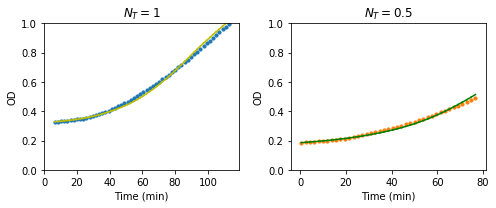

In [21]:
f,axes = plt.subplots(1,2,figsize=(7,3))
x0 = x1[0,1]
for i in range(len(t1)-1):
    t0 = np.linspace(t1[i],t1[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t1[i],t1[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    Vdil =15e3*(1-x1[i+1,1]/x1[i+1,0])
    x0 = (1-Vdil/(15e3))*sol1[-1]
    axes[0].plot(t0,sol1,color='y')
#axes[0].scatter(t1,x1[:,0],color='r',s=10)
axes[0].scatter(t1,x1[:,1],color='C0',s=10)
#axes[0].vlines(t1[-1],0,1,color='g',linewidth=1)

x0 = x2[0,1]
for i in range(len(t2)-1):
    t0 = np.linspace(t2[i],t2[i+1],100)
    #delt = t2[i+1]-t2[i]
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t2[i],t2[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    Vdil =15e3*(1-x2[i+1,1]/x2[i+1,0])
    x0 = (1-Vdil/(15e3))*sol1[-1]
    axes[1].plot(t0,sol1,color='g')    
#axes[1].scatter(t2,x2[:,0],color='r',s=10)
axes[1].scatter(t2,x2[:,1],color='C1',s=10)

for i in range(2):
    axes[i].set_ylabel('OD')
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylim([0,1])
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout()

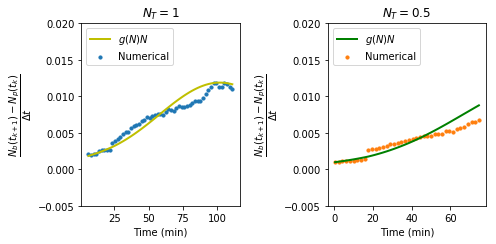

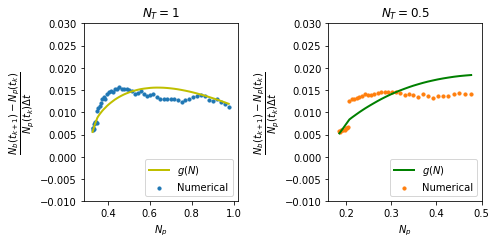

In [23]:
def growth_rate_q0(N,t,q0):
    g=0.0359
    K=1.5355
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-N/K)*N
    return A*B

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(t1[:len(t1)-1],dx1,label='Numerical',color='C0',s=10)
axes[0].plot(t1[:len(t1)-1], growth_rate_q0(x1[:len(t1)-1,1],t1[:len(t1)-1], p_best),color='y', label=r'$g(N)N$',linewidth=2)
axes[1].scatter(t2[:len(t2)-1],dx2,label='Numerical',color='C1',s=10)
axes[1].plot(t2[:len(t2)-1], growth_rate_q0(x2[:len(t2)-1,1],t2[:len(t2)-1], p_best),color='g', label=r'$g(N)N$',linewidth=2)
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')

for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{\Delta t}$')
    axes[i].set_ylim(-0.005,0.02)
    axes[i].legend(loc='upper left')
plt.tight_layout(h_pad=1)

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='Numerical',s=10)
axes[0].plot(x1[:len(t1)-1,1], growth_rate_q0(x1[:len(t1)-1,1],t1[:len(t1)-1], p_best)/x1[:len(t1)-1,1],color='y', label=r'$g(N)$',linewidth=2)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='Numerical',s=10)
axes[1].plot(x2[:len(t2)-1,1], growth_rate_q0(x2[:len(t2)-1,1],t2[:len(t2)-1], p_best)/x2[:len(t2)-1,1],color='g', label=r'$g(N)$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel(r'$N_p$')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{N_p(t_{k}) \Delta t}$')
    axes[i].set_ylim([-0.01,0.03])
    axes[i].legend(loc='lower right')
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout(h_pad=1)


In [24]:
#Optimize g,K,q0 

def sim_discrete(t,z,g,K,q0):
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    return A*B

def err_global(pars,t1,t2,yb1,yb2,yp1,yp2,x01,x02):
    g = pars[0]
    K = pars[1]
    q0 = pars[2]
    N1b = []  #predilution
    N1p = yp1[0]  #postdilution
    x0 =x01
    for i in range(len(t1)-1):
        t0 = np.linspace(t1[i],t1[i+1],100)
        sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t1[i],t1[i+1]], [x0],dense_output=True)
        sol1 =np.ndarray.flatten(sol.sol(t0))
        N1b = np.append(N1b,[sol1[-1]]) 
        Vdil =15e3*(1-x1[i+1,1]/x1[i+1,0])
        x0 = (1-Vdil/(15e3))*sol1[-1]
        N1p = np.append(N1p,[x0])
    
    
    N2b = []  #predilution
    N2p = yp2[0]  #postdilution
    x0 = x02
    for i in range(len(t2)-1):
        t0 = np.linspace(t2[i],t2[i+1],100)
        sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t2[i],t2[i+1]], [x0],dense_output=True)
        sol1 =np.ndarray.flatten(sol.sol(t0))
        N2b = np.append(N2b,[sol1[-1]]) 
        Vdil =15e3*(1-x2[i+1,1]/x2[i+1,0])
        x0 = (1-Vdil/(15e3))*sol1[-1]
        N2p = np.append(N2p,[x0])
        
    er1 = N1b - yb1
    er2 = N2b - yb2
    er3 = N1p - yp1
    er4 = N2p - yp2
    #print(er1)
    #print(er2)
    return np.concatenate((er1, er2,er3,er4))

col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1.0,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)
#x1_data=pd.read_csv("NT10.csv").values
#x1,t1 = clean_data(x1_data,1,col)
#x2_data=pd.read_csv("NT05.csv").values
#x2,t2 = clean_data(x2_data,0.5,col)

dx1 = num_derivative(x1,t1)
dx2 = num_derivative(x2,t2)

Nb1 = x1[1:len(t1),0]
Nb2 = x2[1:len(t2),0]

Np1 = x1[:len(t1),1]
Np2 = x2[:len(t2),1]

p_global = np.array([0.1,1,0.1])
p_best, ier = leastsq(err_global, p_global, args=(t1,t2,Nb1,Nb2,Np1,Np2,x1[0,1],x2[0,1]))

In [25]:
p_best

array([0.02750235, 1.93876738, 0.42255817])

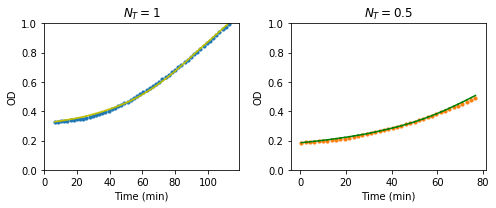

In [27]:
g = p_best[0]
K = p_best[1]
q0 = p_best[2]
f,axes = plt.subplots(1,2,figsize=(7,3))
L=len(t1)
x0 = x1[0,1]
for i in range(L-1):
    t0 = np.linspace(t1[i],t1[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t1[i],t1[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    Vdil =15e3*(1-x1[i+1,1]/x1[i+1,0])
    x0 = (1-Vdil/(15e3))*sol1[-1]    
    axes[0].plot(t0,sol1,color='y')
#axes[0].scatter(t1,x1[:,0],color='r',s=10)
axes[0].scatter(t1,x1[:,1],color='C0',s=10)

L=len(t2)
x0 = x2[0,1]
for i in range(L-1):
    t0 = np.linspace(t2[i],t2[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t2[i],t2[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    Vdil =15e3*(1-x2[i+1,1]/x2[i+1,0])
    x0 = (1-Vdil/(15e3))*sol1[-1]    
    axes[1].plot(t0,sol1,color='g')
#axes[1].scatter(t2,x2[:,0],color='r',s=10)
axes[1].scatter(t2,x2[:,1],color='C1',s=10)

for i in range(2):
    axes[i].set_ylabel('OD')
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylim([0,1])
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout()

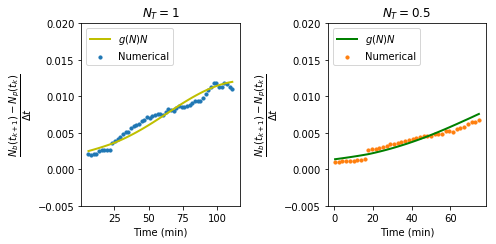

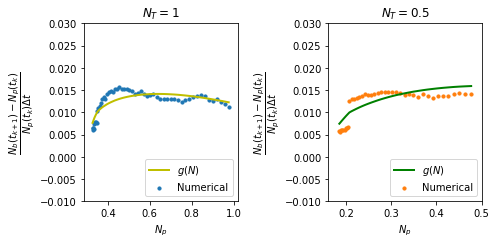

In [28]:
def growth_rate_q0(N,t,g,K,q0):
    A=1./(1+np.exp(-g*t)/q0)
    B=g*(1-N/K)*N
    return A*B

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(t1[:len(t1)-1],dx1,label='Numerical',color='C0',s=10)
axes[0].plot(t1[:len(t1)-1], growth_rate_q0(x1[:len(t1)-1,1],t1[:len(t1)-1],g,K,q0),color='y', label=r'$g(N)N$',linewidth=2)
axes[1].scatter(t2[:len(t2)-1],dx2,label='Numerical',color='C1',s=10)
axes[1].plot(t2[:len(t2)-1], growth_rate_q0(x2[:len(t2)-1,1],t2[:len(t2)-1],g,K,q0),color='g', label=r'$g(N)N$',linewidth=2)
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{\Delta t}$')
    axes[i].set_ylim(-0.005,0.02)
    axes[i].legend(loc='upper left')
plt.tight_layout(h_pad=1)

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='Numerical',s=10)
axes[0].plot(x1[:len(t1)-1,1], growth_rate_q0(x1[:len(t1)-1,1],t1[:len(t1)-1],g,K,q0)/x1[:len(t1)-1,1],color='y', label=r'$g(N)$',linewidth=2)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='Numerical',s=10)
axes[1].plot(x2[:len(t2)-1,1], growth_rate_q0(x2[:len(t2)-1,1],t2[:len(t2)-1],g,K,q0)/x2[:len(t2)-1,1],color='g', label=r'$g(N)$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel(r'$N_p$')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{N_p(t_{k}) \Delta t}$')
    axes[i].set_ylim([-0.01,0.03])
    axes[i].legend(loc='lower right')
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout(h_pad=1)

Numerical data generate

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

In [115]:
np.random.uniform(-50,0)

-48.01538882459772

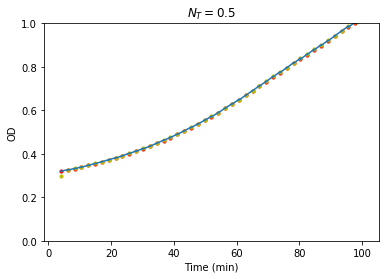

In [116]:
def sim_discrete(t,z,q0):
    g=0.034
    K=1.5
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    return A*B


t1 =  np.linspace(4,100,45)
p_best = 0.5
f = plt.figure()

Np=[0.32]
Nb=[0.3]
x0=Np[0]
for i in range(len(t1)-1):
    t0 = np.linspace(t1[i],t1[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t1[i],t1[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))#+np.random.exponential(0.001)#*np.sign(np.random.uniform(-1,1))
    Nb = np.append(Nb,[sol1[-1]])
    #x0 = (1-(200)/(15e3))*sol1[-1]#+np.random.exponential(0.006)#*np.sign(np.random.uniform(-1,1))
    x0 = (1-np.random.uniform(0,100)/(15e3))*sol1[-1]
    Np = np.append(Np,[x0])
    plt.plot(t0,sol1,color='C0')
plt.scatter(t1,Np,color='r',s=10)
plt.scatter(t1,Nb,color='y',s=10)
plt.title(r'$N_T=0.5$')
plt.ylim([0,1])
plt.xlabel('Time (min)')
plt.ylabel('OD')


def num_derivative(x,t):
    d = np.zeros(len(t)-1)
    for i in range(len(t)-1):
        d[i] = (x[i+1,0]-x[i,1])/(t[i+1]-t[i])
    return d

x1 = np.column_stack((Nb,Np))
#tx1= x1
dx1 = num_derivative(x1,t1)
#f = plt.figure()
#plt.scatter(t1[:-1],dx1,c='r',s=2)
#plt.scatter(t1,sim_discrete(t1,x1[:,1],p_best),c='g',s=2)
#plt.ylim([0,0.02])

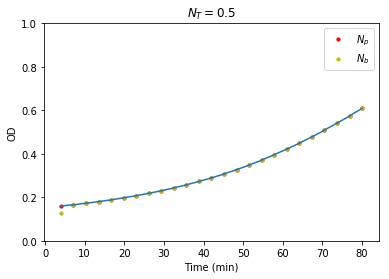

In [117]:
f = plt.figure()
t2 =np.linspace(4,80,25)

Np=[0.16]
Nb=[0.13]
x0=Np[0]
for i in range(len(t2)-1):
    t0 = np.linspace(t2[i],t2[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t2[i],t2[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))#+np.random.exponential(0.001)#*np.sign(np.random.uniform(-1,1))
    Nb = np.append(Nb,[sol1[-1]])
    #x0 = (1-(200)/(15e3))*sol1[-1]#+np.random.exponential(0.006)#*np.sign(np.random.uniform(-1,1))
    x0 = (1-np.random.uniform(-50,0)/(15e3))*sol1[-1]
    Np = np.append(Np,[x0])
    plt.plot(t0,sol1,color='C0')
plt.scatter(t2,Np,color='r',s=10,label=r'$N_p$')
plt.scatter(t2,Nb,color='y',s=10,label=r'$N_b$')
plt.title(r'$N_T=0.5$')
plt.ylim([0,1])
plt.xlabel('Time (min)')
plt.ylabel('OD')
plt.legend()

def num_derivative(x,t):
    d = np.zeros(len(t)-1)
    for i in range(len(t)-1):
        d[i] = (x[i+1,0]-x[i,1])/(t[i+1]-t[i])
    return d

x2 = np.column_stack((Nb,Np))
#tx2= x2
dx2 = num_derivative(x2,t2)
#f = plt.figure()
#plt.scatter(t2[:-1],dx2,c='r',s=2)
#plt.scatter(t2,sim_discrete(t2,x2[:,1],p_best),c='g',s=2)
#plt.ylim([0,0.02])

f,axes = plt.subplots(1,2,figsize=(7,3))
x0 = x1[0,1]
for i in range(len(t1)-1):
    t0 = np.linspace(t1[i],t1[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t1[i],t1[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    x0 = (1-200/(15e3))*sol1[-1]
    axes[0].plot(t0,sol1,color='y')
#axes[0].scatter(t1,x1[:,0],color='r',s=10)
axes[0].scatter(t1,x1[:,1],color='C0',s=10)
#axes[0].vlines(t1[-1],0,1,color='g',linewidth=1)

x0 = x2[0,1]
for i in range(len(t2)-1):
    t0 = np.linspace(t2[i],t2[i+1],100)
    #delt = t2[i+1]-t2[i]
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,p_best), [t2[i],t2[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    x0 = (1-200/(15e3))*sol1[-1]
    axes[1].plot(t0,sol1,color='g')    
#axes[1].scatter(t2,x2[:,0],color='r',s=10)
axes[1].scatter(t2,x2[:,1],color='C1',s=10)

for i in range(2):
    axes[i].set_ylabel('OD')
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylim([0,1])
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout()

optimize separately

In [119]:
#Optimize g,K,q0 

def sim_discrete(t,z,g,K,q0):
    A=1./(1+(1./q0)*np.exp(-g*t))
    B=g*(1-z/K)*z
    return A*B

def err_global(pars,t1,t2,yb1,yb2,yp1,yp2,x01,x02):
    g = pars[0]
    K = pars[1]
    q0 = pars[2]
    N1b = []  #predilution
    N1p = yp1[0]  #postdilution
    x0 =x01
    for i in range(len(t1)-1):
        t0 = np.linspace(t1[i],t1[i+1],100)
        sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t1[i],t1[i+1]], [x0],dense_output=True)
        sol1 =np.ndarray.flatten(sol.sol(t0))
        N1b = np.append(N1b,[sol1[-1]]) 
        x0 = (1-200/(15e3))*sol1[-1]
        N1p = np.append(N1p,[x0])
    
    
    N2b = []  #predilution
    N2p = yp2[0]  #postdilution
    x0 = x02
    for i in range(len(t2)-1):
        t0 = np.linspace(t2[i],t2[i+1],100)
        sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t2[i],t2[i+1]], [x0],dense_output=True)
        sol1 =np.ndarray.flatten(sol.sol(t0))
        N2b = np.append(N2b,[sol1[-1]]) 
        x0 = (1-200/(15e3))*sol1[-1]
        N2p = np.append(N2p,[x0])
        
    er1 = N1b - yb1
    er2 = N2b - yb2
    er3 = N1p - yp1
    er4 = N2p - yp2
    #print(er1)
    #print(er2)
    return np.concatenate((er1, er2,er3,er4))


Nb1 = x1[1:len(t1),0]
Nb2 = x2[1:len(t2),0]

Np1 = x1[:len(t1),1]
Np2 = x2[:len(t2),1]

p_global = np.array([0.1,1,0.1])
p_best, ier = leastsq(err_global, p_global, args=(t1,t2,Nb1,Nb2,Np1,Np2,x1[0,1],x2[0,1]))

In [120]:
p_best

array([0.03603585, 1.80417798, 0.74809351])

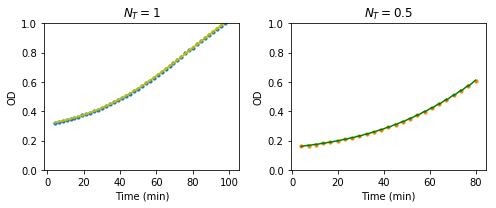

In [126]:
g = p_best[0]
K = p_best[1]
q0 = p_best[2]
f,axes = plt.subplots(1,2,figsize=(7,3))
L=len(t1)
x0 = x1[0,1]
for i in range(L-1):
    t0 = np.linspace(t1[i],t1[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t1[i],t1[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    x0 = (1-200/(15e3))*sol1[-1]
    axes[0].plot(t0,sol1,color='y')
#axes[0].scatter(t1,x1[:,0],color='r',s=10)
axes[0].scatter(t1,x1[:,1],color='C0',s=10)

L=len(t2)
x0 = x2[0,1]
for i in range(L-1):
    t0 = np.linspace(t2[i],t2[i+1],100)
    sol = solve_ivp(lambda t, z: sim_discrete(t,z,g,K,q0), [t2[i],t2[i+1]], [x0],dense_output=True)
    sol1 =np.ndarray.flatten(sol.sol(t0))
    x0 = (1-200/(15e3))*sol1[-1]
    axes[1].plot(t0,sol1,color='g')
#axes[1].scatter(t2,x2[:,0],color='r',s=10)
axes[1].scatter(t2,x2[:,1],color='C1',s=10)

for i in range(2):
    axes[i].set_ylabel('OD')
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylim([0,1])
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout()

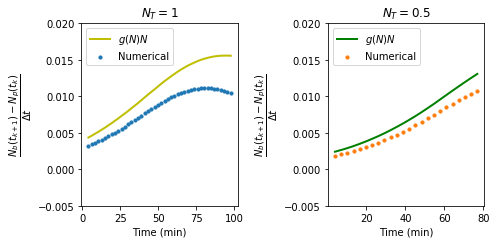

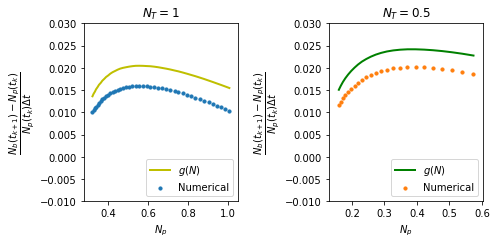

In [112]:
def growth_rate_q0(N,t,g,K,q0):
    A=1./(1+np.exp(-g*t)/q0)
    B=g*(1-N/K)*N
    return A*B

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(t1[:len(t1)-1],dx1,label='Numerical',color='C0',s=10)
axes[0].plot(t1[:len(t1)-1], growth_rate_q0(x1[:len(t1)-1,1],t1[:len(t1)-1],g,K,q0),color='y', label=r'$g(N)N$',linewidth=2)
axes[1].scatter(t2[:len(t2)-1],dx2,label='Numerical',color='C1',s=10)
axes[1].plot(t2[:len(t2)-1], growth_rate_q0(x2[:len(t2)-1,1],t2[:len(t2)-1],g,K,q0),color='g', label=r'$g(N)N$',linewidth=2)
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
for i in range(2):
    axes[i].set_xlabel('Time (min)')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{\Delta t}$')
    axes[i].set_ylim(-0.005,0.02)
    axes[i].legend(loc='upper left')
plt.tight_layout(h_pad=1)

f,axes = plt.subplots(1,2,figsize=(7,3.5))
axes[0].scatter(x1[:len(t1)-1,1],dx1/x1[:len(t1)-1,1],color='C0',label='Numerical',s=10)
axes[0].plot(x1[:len(t1)-1,1], growth_rate_q0(x1[:len(t1)-1,1],t1[:len(t1)-1],g,K,q0)/x1[:len(t1)-1,1],color='y', label=r'$g(N)$',linewidth=2)
axes[1].scatter(x2[:len(t2)-1,1],dx2/x2[:len(t2)-1,1],color='C1',label='Numerical',s=10)
axes[1].plot(x2[:len(t2)-1,1], growth_rate_q0(x2[:len(t2)-1,1],t2[:len(t2)-1],g,K,q0)/x2[:len(t2)-1,1],color='g', label=r'$g(N)$',linewidth=2)
for i in range(2):
    axes[i].set_xlabel(r'$N_p$')
    axes[i].set_ylabel(r'$\dfrac{N_b(t_{k+1})-N_p(t_{k})}{N_p(t_{k}) \Delta t}$')
    axes[i].set_ylim([-0.01,0.03])
    axes[i].legend(loc='lower right')
axes[0].set_title(r'$N_T=1$')
axes[1].set_title(r'$N_T=0.5$')
plt.tight_layout(h_pad=1)

col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1.0,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)

In [127]:
L=len(t1)-1
err1 = np.zeros(L)
for i in range(L):
    err1[i] = x1[i+1,1]-(1-200/15e3)*x1[i+1,0]
    
L=len(t2)-1
err2 = np.zeros(L)
for i in range(L):
    err2[i] = x2[i+1,1]-(1-200/15e3)*x2[i+1,0]

(array([183.03047558, 305.05079263, 244.0406341 , 122.02031705,
         61.01015853, 183.03047558, 122.02031705,  61.01015853,
         61.01015853, 122.02031705]),
 array([0.00224589, 0.00292883, 0.00361178, 0.00429473, 0.00497767,
        0.00566062, 0.00634356, 0.00702651, 0.00770946, 0.0083924 ,
        0.00907535]),
 <a list of 10 Patch objects>)

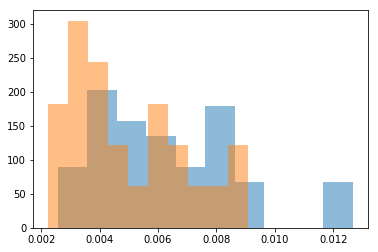

In [128]:
plt.hist(err1,density=True,alpha=0.5)
plt.hist(err2,density=True,alpha=0.5)

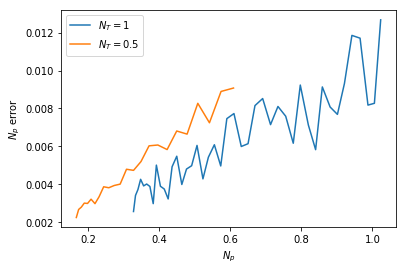

In [129]:
plt.plot(x1[1:,0],err1,c='C0',label=r'$N_T=1$')
plt.plot(x2[1:,0],err2,c='C1',label=r'$N_T=0.5$')
plt.ylabel(r'$N_p$ error')
plt.xlabel(r'$N_p$')
plt.legend()

from sklearn.linear_model import LinearRegression
model1 = LinearRegression().fit(x1[1:,0].reshape(-1, 1),err1.reshape(-1, 1))
model2 = LinearRegression().fit(x2[1:,0].reshape(-1, 1),err2.reshape(-1, 1))


In [ ]:
print([model1.intercept_,model1.coef_])
print([model2.intercept_,model2.coef_])

Text(0.5, 0, '$V_dil$')

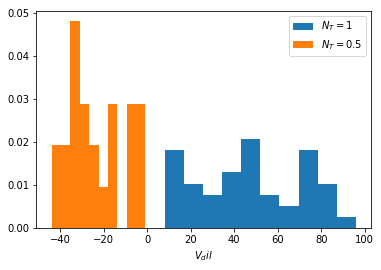

In [130]:
L=len(t1)-1
vdil1 = np.zeros(L)
for i in range(L):
    vdil1[i] = 15e3*(1-x1[i+1,1]/x1[i+1,0])
    
L=len(t2)-1
vdil2 = np.zeros(L)
for i in range(L):
    vdil2[i] = 15e3*(1-x2[i+1,1]/x2[i+1,0])
    
plt.hist(vdil1,density=True,label=r'$N_T=1$')
plt.hist(vdil2,density=True,label=r'$N_T=0.5$')
plt.legend()
plt.xlabel(r'$V_dil$')

In [ ]:
np.mean(err2)

In [ ]:
np.random.exponential(5)

In [ ]:
col=1
x1_data=pd.read_csv("sN1.csv").values
x1,t1 = clean_data(x1_data,1.0,col)
x2_data=pd.read_csv("sN05.csv").values
x2,t2 = clean_data(x2_data,0.5,col)

L=len(t1)-1
vdil1 = np.zeros(L)
for i in range(L):
    vdil1[i] = 15e3*(1-x1[i+1,1]/x1[i+1,0])
    
L=len(t2)-1
vdil2 = np.zeros(L)
for i in range(L):
    vdil2[i] = 15e3*(1-x2[i+1,1]/x2[i+1,0])

In [ ]:
plt.hist(vdil1,density=True,label=r'$N_T=1$')
plt.hist(vdil2,density=True,label=r'$N_T=0.5$')
plt.legend()
plt.xlabel(r'$V_dil$')

In [ ]:
vdil2

In [88]:
err2

array([0.00238594, 0.00383426, 0.00387425, 0.00319317, 0.00443874,
       0.00384237, 0.00267465, 0.00413443, 0.00465873, 0.00318186,
       0.00341838, 0.00472906, 0.00446403, 0.00433473, 0.00339315,
       0.00340723, 0.00541175, 0.00536328, 0.00516066, 0.00460151,
       0.00669772, 0.00451578, 0.00770674, 0.00551156, 0.00624851,
       0.00617808, 0.00473086, 0.00619584, 0.00630425, 0.00871047,
       0.00514396, 0.00821221, 0.00666114, 0.00600745, 0.00682998,
       0.00935224, 0.00879873, 0.00830928, 0.01148132, 0.01069054,
       0.00895091, 0.01175387, 0.01058964, 0.00967857])

In [31]:
np.log(2)/0.0275

25.205352020361648